In [1]:
from matplotlib import pyplot as plt
from dataclasses import dataclass
from typing import Callable
import numpy as np


# Random walk


In [2]:
class Solver:
    pass


@dataclass
class RndWalkSolver(Solver):
    dim: int
    mn: np.array
    mx: np.array
    stp: float
    atmps: int = 100

    def get_rnd_point(self):  # Apply rand to min max range
        return self.mn + (np.random.rand(1, self.dim) * (self.mx - self.mn))

    def get_rnd_step(self, pnt):
        end = None

        for i in range(1000):  # Prevent infinite loops
            if end is not None and (end < self.mx).all() and (end > self.mn).all():
                break

            end = pnt

            # Make a step in random direction in n dimensional space
            # step is a distance between 2 points, given by step = sqrt(x1**2 + x2**2 + x3**2 +...)
            # then step**2 is a sum of steps in each direction**2.
            # Due to implementation restricts first assume step is 1 then resize sum of squares to required step.
            d = np.sqrt(
                np.random.dirichlet(
                    # Assume step size is 1 -> 1**2 is sqrt(x1**2 + x2**2 + x3**2 +...)
                    np.ones(self.dim), size=1**2
                ) * self.stp**2  # Resize to required step size
            )
            # Change direction randomly (otherwise function will only grow)
            d = np.where(
                np.random.choice(
                    a=[False, True],
                    size=(1, self.dim)
                ), -d, d
            )

            end = pnt + d
        else:  # Not feasible in N iterations
            raise RuntimeError('Not feasible')

        return end

    def solve(self, trg: Callable[[np.array], np.array], cmp: Callable[[float, float], bool], vis=False):
        ax = None
        if vis:
            ax = plt.subplot()

        bst = self.get_rnd_point()
        bst_f = trg(bst)

        lst = bst
        for i in range(self.atmps):
            tst = self.get_rnd_step(lst)
            tst_f = trg(tst)

            if cmp(bst_f, tst_f):
                bst, bst_f = tst, tst_f

            if ax is not None and self.dim == 2:
                ax.plot([
                    lst[0][0],
                    tst[0][0],
                ], [
                    lst[0][1],
                    tst[0][1]
                ], color='b', alpha=0.2)
                ax.scatter(tst[0][0], tst[0][1], s=tst_f, color='b', alpha=0.2)

            lst = tst

        if ax is not None and self.dim == 2:
            ax.scatter(bst[0][0], bst[0][1], s=bst_f, color='r', alpha=0.5)
        
        return bst, bst_f


(array([[3.52062293, 3.54464453]]), 41.22036045260247)

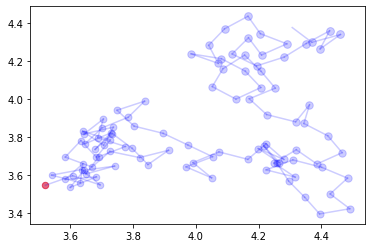

In [3]:
def target(x: np.array):
    return np.sum(x**2+4*x-6)


slv = RndWalkSolver(2, np.array([2, 2]), np.array([4.5, 4.5]), 0.1, 100)
slv.solve(target, lambda bp, tp: tp < bp, True)


# Neuron net work


In [12]:
@dataclass
class N:
    w: float
    b: float

    def internal_potencial(self, x):
        return np.dot(x, self.w) + self.b


@dataclass
class ThresholdN(N):
    threshold: float
    act_fn: Callable[[np.array], float]

    def apply(self, x):
        ip = self.internal_potencial(x)
        return 1 if self.act_fn(ip) >= self.threshold else 0


In [13]:
data = [
    [np.array((0, 0)), 0],
    [np.array((0, 1)), 0],
    [np.array((1, 0)), 0],
    [np.array((1, 1)), 1],
]

In [34]:
def metrics(w_b_thr):
    *w, b, threshold = w_b_thr[0]
    n = ThresholdN(
        w=w, b=b,
        threshold=threshold,
        act_fn=np.tanh
    )

    match = 0
    for x, y in data:
        if n.apply(x) == y:
            match += 1

    return match


slv = RndWalkSolver(4, np.array([0, 0, -1, 0]),
                    np.array([1, 1, 1, 1]), 0.1, 100)
tweaks, score = slv.solve(metrics, lambda bp, tp: tp > bp, False)
print(f'best: {tweaks}, score: {score}')

*w, b, threshold = tweaks[0]

n = ThresholdN(w=w, b=b, threshold=threshold, act_fn=np.tanh)

for x, y in data:
    p_y = n.apply(x)
    print(f'{x} -> {p_y} ({y})')


best: [[0.52018782 0.40411763 0.88186081 0.9331392 ]], score: 4
[0 0] -> 0 (0)
[0 1] -> 0 (0)
[1 0] -> 0 (0)
[1 1] -> 1 (1)
